<a href="https://colab.research.google.com/github/Seenuprime/Pneumonia_detector/blob/main/Pneumonia_Detector(Pytorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!kaggle datasets download pcbreviglieri/pneumonia-xray-images

Dataset URL: https://www.kaggle.com/datasets/pcbreviglieri/pneumonia-xray-images
License(s): Attribution 4.0 International (CC BY 4.0)
100% 1.14G/1.14G [00:31<00:00, 34.8MB/s]
100% 1.14G/1.14G [00:31<00:00, 39.3MB/s]


In [2]:
import zipfile
zipfile = zipfile.ZipFile('pneumonia-xray-images.zip')
zipfile.extractall()
zipfile.close()

### About Dataset


Content:

Adapted version of Paul Mooney's 'Chest X-Ray Images (Pneumonia)' dataset, where the amount of observations for training and validation purposes was redistributed to allow for a more balanced machine learning exercise.

Total number of observations (images): 5,856

Training observations: 4,192 (1,082 normal cases, 3,110 lung opacity cases)

Validation observations: 1,040 (267 normal cases, 773 lung opacity cases)

Testing observations: 624 (234 normal cases, 390 lung opacity cases)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [4]:
import os

classes = sorted(os.listdir('train'))
print(classes)

['normal', 'opacity']


### Lung Opacity Meaning:

In pneumonia, opacity refers to the hazy gray areas that can show up in CT scans or X-rays of the lungs. These areas indicate increased density within the lungs, which could suggest fluid in air spaces, thickening of air space walls, thickening of lung tissue, inflammation, or pulmonary edema. Opacity can be a sign of pneumonia, and it may indicate that something is partially filling the air spaces inside the lungs. Ground-glass opacity (GGO) is a specific type of opacity that can be seen in pneumonia and other respiratory conditions. It is often associated with viral or bacterial infections and can be a common finding in patients with moderate to severe respiratory conditions, including those infected with COVID-19.

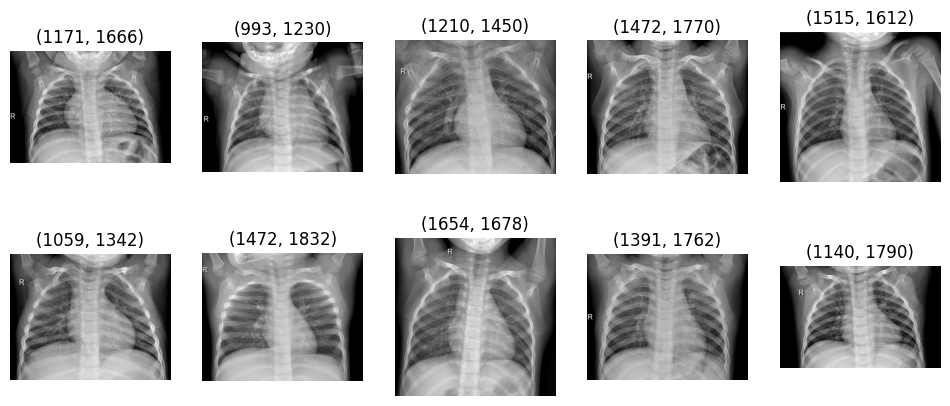

In [5]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import random

train_normal = 'train/normal'
image_files = os.listdir(train_normal)
figure = plt.figure(figsize=(12, 5))
cols, rows = 5, 2

for i in range(1, cols*rows+1):
  rand_indx = random.randint(0, len(image_files)-1)
  image = cv.imread(os.path.join(train_normal, image_files[rand_indx]), 0)
  plt.subplot(rows, cols, i)
  plt.imshow(image, cmap='gray')
  plt.title(image.shape)
  plt.axis(False)

Our images has different shapes so we hava to make all image shapes as same

we will make all our image shapes to 128x128

In [6]:
transform = transforms.Compose([
    transforms.Resize((128, 128)), ## Reshaping the images
    transforms.Grayscale(),
    transforms.ToTensor(), ## Converting to tensor
    transforms.Normalize((0.5, ), (0.5, )) ## Mean of 0.5 and Std of 0.5
])

In [7]:
train_dataset = datasets.ImageFolder('./train', transform=transform)
val_dataset = datasets.ImageFolder('./val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

torch.Size([128, 128])
torch.Size([128, 128])
torch.Size([128, 128])
torch.Size([128, 128])
torch.Size([128, 128])
torch.Size([128, 128])
torch.Size([128, 128])
torch.Size([128, 128])
torch.Size([128, 128])
torch.Size([128, 128])


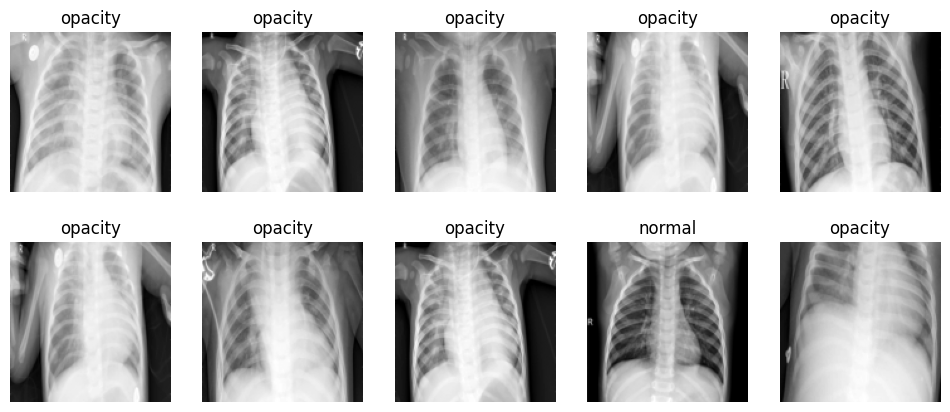

In [8]:
images, labels = next(iter(train_loader))

figure = plt.figure(figsize=(12, 5))
cols, rows = 5, 2

for i in range(1, cols*rows+1):
  rand_indx = random.randint(0, len(labels)-1)
  img = images[rand_indx].squeeze()
  print(img.shape)
  plt.subplot(rows, cols, i)
  plt.imshow(img, cmap='gray')
  plt.title(classes[labels[rand_indx].item()])
  plt.axis(False)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [10]:
class Cnn(nn.Module):
  def __init__(self):
    super(Cnn, self).__init__()

    self.conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1), ## 1x128x128 --> 16x128x128
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2), # 16x64x64
        nn.Conv2d(16, 32, 3, 1, 1), # 32x64x64
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # 32x32x32
        nn.Conv2d(32, 16, 2, 1, 1), # 16x32x32
        nn.ReLU(),
        nn.MaxPool2d(2, 2) # 16x16x16
    )

    self.fc = nn.Sequential(
        nn.Flatten(), # 16*16*16
        nn.Linear(16*16*16, 784),
        nn.ReLU(),
        nn.Linear(784, 2), # 2 output for binary classification (normal/pneumonia)
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.conv_layer(x)
    x = self.fc(x)
    return x

model = Cnn().to(device)

In [11]:
model

Cnn(
  (conv_layer): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=784, bias=True)
    (2): ReLU()
    (3): Linear(in_features=784, out_features=2, bias=True)
    (4): Sigmoid()
  )
)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
epochs = 10
best_val_acc = 0
for epoch in range(epochs):
  model.train()
  training_loss = 0
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)

    loss = criterion(outputs, labels)
    training_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  avg_train_loss = training_loss / len(train_loader)

  model.eval()
  correct = 0
  total = 0
  val_loss = 0
  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)

      loss = criterion(outputs, labels)
      val_loss += loss.item()

      preds = torch.max(outputs, 1)[1]
      correct += (preds == labels).sum().item()
      total += labels.size(0)

  avg_val_loss = val_loss / len(val_loader)
  val_accuracy = 100 * correct / total
  print(f"Epochs: {epoch+1}/{epochs}, train_loss: {avg_train_loss:.4f}, val_loss: {avg_val_loss:.4f}, val_acc: {val_accuracy:.4f}")

  if best_val_acc < val_accuracy:
    best_val_acc = val_accuracy
    torch.save(model.state_dict(), "Pneumonia_pytorch.pth")

  print(f"Best validation accuracy: {best_val_acc}")

Epochs: 1/10, train_loss: 0.5728, val_loss: 0.5661, val_acc: 74.3269
Best validation accuracy: 74.32692307692308
Epochs: 2/10, train_loss: 0.5714, val_loss: 0.5661, val_acc: 74.3269
Best validation accuracy: 74.32692307692308
Epochs: 3/10, train_loss: 0.5714, val_loss: 0.5661, val_acc: 74.3269
Best validation accuracy: 74.32692307692308
Epochs: 4/10, train_loss: 0.5714, val_loss: 0.5661, val_acc: 74.3269
Best validation accuracy: 74.32692307692308
Epochs: 5/10, train_loss: 0.5714, val_loss: 0.5661, val_acc: 74.3269
Best validation accuracy: 74.32692307692308
Epochs: 6/10, train_loss: 0.5714, val_loss: 0.5661, val_acc: 74.3269
Best validation accuracy: 74.32692307692308
Epochs: 7/10, train_loss: 0.5714, val_loss: 0.5661, val_acc: 74.3269
Best validation accuracy: 74.32692307692308
Epochs: 8/10, train_loss: 0.5714, val_loss: 0.5661, val_acc: 74.3269
Best validation accuracy: 74.32692307692308
Epochs: 9/10, train_loss: 0.5714, val_loss: 0.6654, val_acc: 74.3269
Best validation accuracy: 7

In [14]:
test_dataset = datasets.ImageFolder('./test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, pred = torch.max(outputs, 1)

        correct += (pred == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total * 100
print(accuracy)

62.5


In [16]:
model = Cnn().to(device)
model.load_state_dict(torch.load('Pneumonia_pytorch.pth'))

model.eval()

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, pred = torch.max(outputs, 1)

        correct += (pred == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total * 100
print(accuracy)

<ipython-input-16-bcbbef870942>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Pneumonia_pytorch.pth'))


62.5
